In [1]:
%matplotlib inline


DSS example
===========

Find the linear combinations of multichannel data that maximize repeatability
over trials.

Uses meegkit.dss0().



In [2]:
import matplotlib.pyplot as plt
import numpy as np

from meegkit import dss
from meegkit.utils import unfold, rms, fold, tscov

import config

Create simulated data
-----------------------------------------------------------------------------



In [3]:
# Data are time * channel * trials.
n_samples = 100 * 3
n_chans = 30
n_trials = 100
noise_dim = 20  # dimensionality of noise

# Source signal
source = np.hstack((
    np.zeros((n_samples // 3,)),
    np.sin(2 * np.pi * np.arange(n_samples // 3) / (n_samples / 3)).T,
    np.zeros((n_samples // 3,))))[np.newaxis].T
s = source * np.random.randn(1, n_chans)  # 300 * 30
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, 100))

# Noise
noise = np.dot(
    unfold(np.random.randn(n_samples, noise_dim, n_trials)),
    np.random.randn(noise_dim, n_chans))
noise = fold(noise, n_samples)

# Mix signal and noise
SNR = 0.1
data = noise / rms(noise.flatten()) + SNR * s / rms(s.flatten())

Apply DSS to clean them
-----------------------------------------------------------------------------



In [4]:
# Compute original and biased covariance matrices
c0, _ = tscov(data)

# In this case the biased covariance is simply the covariance of the mean over
# trials
c1, _ = tscov(np.mean(data, 2))

# Apply DSS
[todss, _, pwr0, pwr1] = dss.dss0(c0, c1)
z = fold(np.dot(unfold(data), todss), epoch_size=n_samples)

# Find best components
best_comp = np.mean(z[:, 0, :], -1)

Plot results
-----------------------------------------------------------------------------



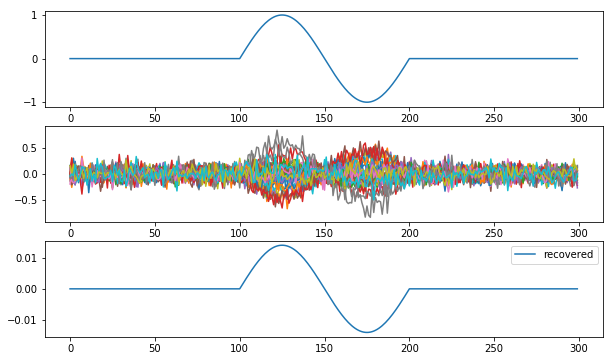

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(source, label='source')
ax2.plot(np.mean(data, 2), label='data')
ax3.plot(best_comp, label='recovered')
plt.legend()
plt.show()